In [9]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels as sts
from math import sqrt
from pickle import dump, load
from scipy.interpolate import interp1d
from statsmodels.stats.weightstats import ttest_ind

Загрузим и обработаем наш датасет

In [10]:
def load_dataset():
    global outset
    df_people = pd.read_csv("boston/Most Recent Data - Released 5.10.2022 (Recommended)/1c_COVID19_demographics_cleaned_deid_2022-02-06_17_39.csv")
    df_people = df_people[["sub_id", "country", "bio_sex", "age1", "marital", "medical", "disability___1", "disability___2"]]
    df_people["problems_sensors"] = df_people.pop("disability___1")
    df_people["problems_mobility"] = df_people.pop("disability___2")
    
    df_sleep = pd.read_csv("boston/Most Recent Data - Released 5.10.2022 (Recommended)/2c_COVID19_daily_survey_ALL_cleaned_deid_2022-02-06_17_39.csv", sep = ',')
    need_rows = ["sleepdiary_fallasleep", "sleepdiary_sleeplatency", "sleepdiary_wakes", "sleepdiary_waketime", "steps", "stress", "covid_status", "PHQ9"]
    df_sleep = df_sleep[["sub_id"] + need_rows]


    # usually takes a long time, then:
    try:
        df_sleep = load(open("df_sleep_dumpfile", 'rb'))
        print("Downloaded df_sleep")
    except:
        forqualitysleep_dict = dict()
        for ind, row in df_sleep.iterrows():
            for i in need_rows:
                rowi = row[i]
                if type(rowi) == str:
                    rowi = int(rowi.split(':')[0]) * 60 + int(rowi.split(':')[1])
                    if i in "sleepdiary_fallasleep":
                        # if not 6 * 60 < rowi < 12 * 60: # for mistake with 12-hours clock, not 24
                        rowi -= 14 * 60
                        rowi %= 24 * 60
                        rowi += 14 * 60
                if i == "stress":
                    rowi = 7 - rowi + 1
                df_sleep.loc[ind, i] = rowi
            df_sleep.loc[ind, "time_sleep"] = df_sleep.loc[ind, "sleepdiary_waketime"] - df_sleep.loc[ind, "sleepdiary_fallasleep"]

        for i in need_rows:
            forqualitysleep_dict[i] = df_sleep[i].dropna()
        forqualitysleep_dict["time_sleep"] = df_sleep["time_sleep"].dropna()
        print("get all without quality sleep")
        
        ind_percentile = dict()
        for i in forqualitysleep_dict:
            forqualitysleep_dict[i].sort_values()
            def func(x, i = i):
                if x == np.nan:
                    return 0.5
                else:
                    return forqualitysleep_dict[i].searchsorted(x) / len(forqualitysleep_dict[i])
            ind_percentile[i] = func

        print("prepared to create quality sleep")

        for ind, row in df_sleep.iterrows():
            rowi = sqrt(ind_percentile["time_sleep"](row["sleepdiary_waketime"] - row["sleepdiary_fallasleep"]) ** 2
                        + (1 - ind_percentile["sleepdiary_sleeplatency"](row["sleepdiary_sleeplatency"])) ** 2
                        + (1 - ind_percentile["sleepdiary_wakes"](row["sleepdiary_wakes"])) ** 2) / sqrt(3)
            df_sleep.loc[ind, "quality_sleep"] = rowi
        
        dump(df_sleep, open("df_sleep_dumpfile", 'wb')) # dumping
    
    # usually takes a long time, then:
    try:
        df_people = load(open("df_people_dumpfile", 'rb'))
        print("Downloaded df_people")
    except:
        print("Creating df_people table")
        need_rows.append("time_sleep")
        need_rows.append("quality_sleep")

        sleepdict = dict()
        for ind, row in df_sleep.iterrows():
            for i in need_rows:
                if row[i] != np.nan:
                    if (row["sub_id"], i) in sleepdict:
                        sleepdict[(row["sub_id"], i)] = np.append(sleepdict[(row["sub_id"], i)], row[i])
                    else:
                        sleepdict[(row["sub_id"], i)] = np.array([row[i]])
        
        for i in need_rows:
            df_people[i] = np.nan

        for ind, row in df_people.iterrows():
            sub_id = df_people.loc[ind, "sub_id"]
            for i in need_rows:
                if (sub_id, i) in sleepdict:
                    sleepdict[(sub_id, i)] = sleepdict[(sub_id, i)][~np.isnan(sleepdict[(sub_id, i)])]
                    if i == "covid_status":
                        df_people.loc[ind, i] = np.max(sleepdict[(sub_id, i)])
                    else:
                        df_people.loc[ind, i] = np.mean(sleepdict[(sub_id, i)])
        
        dump(df_people, open("df_people_dumpfile", 'wb')) # dumping

    return df_people, df_sleep

df_people, df_sleep = load_dataset()

In [ ]:
df_people.corr().style.background_gradient(cmap='coolwarm')

/tmp/ipykernel_155771/915340017.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_people.corr().style.background_gradient(cmap='coolwarm')


,sub_id,bio_sex,age1,marital,medical,problems_sensors,problems_mobility,sleepdiary_fallasleep,sleepdiary_sleeplatency,sleepdiary_wakes,sleepdiary_waketime,steps,stress,covid_status,PHQ9,time_sleep,quality_sleep
sub_id,1.000000,0.000380,-0.113975,-0.081446,0.051533,0.025491,0.041549,0.087475,0.123102,-0.080182,0.042250,-0.001907,0.049809,0.032888,0.187291,-0.049325,-0.063054
bio_sex,0.000380,1.000000,-0.002937,-0.079287,0.016345,0.083576,-0.003465,0.015985,0.010017,-0.017111,0.035914,0.060609,-0.125006,0.026145,-0.045965,0.014923,-0.007415
age1,-0.113975,-0.002937,1.000000,0.534808,0.107086,0.147853,0.113933,-0.206427,-0.045392,0.231597,-0.320864,0.022324,-0.196886,0.054589,-0.222260,-0.081419,-0.177830
marital,-0.081446,-0.079287,0.534808,1.000000,0.056815,0.061651,0.017749,-0.194587,-0.065296,0.150917,-0.276721,0.017508,-0.087589,0.075184,-0.167869,-0.050111,-0.115931
medical,0.051533,0.016345,0.107086,0.056815,1.000000,0.042857,0.199796,-0.008630,0.024745,0.078939,0.003307,0.001399,0.050873,0.042806,0.101051,0.011120,-0.055274
problems_sensors,0.025491,0.083576,0.147853,0.061651,0.042857,1.000000,0.066511,0.040519,0.021727,0.001328,0.012030,-0.043387,-0.043886,-0.027202,-0.001186,-0.030564,-0.010167
problems_mobility,0.041549,-0.003465,0.113933,0.017749,0.199796,0.066511,1.000000,0.030995,0.008071,0.014250,-0.024401,-0.067508,0.004189,0.019136,0.030631,-0.053641,-0.058234
sleepdiary_fallasleep,0.087475,0.015985,-0.206427,-0.194587,-0.008630,0.040519,0.030995,1.000000,0.069389,-0.136449,0.458484,-0.199136,0.079498,-0.002534,0.148499,-0.595795,-0.172618
sleepdiary_sleeplatency,0.123102,0.010017,-0.045392,-0.065296,0.024745,0.021727,0.008071,0.069389,1.000000,0.147164,0.122000,-0.133610,0.185465,0.006355,0.325729,0.043345,-0.424408
sleepdiary_wakes,-0.080182,-0.017111,0.231597,0.150917,0.078939,0.001328,0.014250,-0.136449,0.147164,1.000000,-0.091190,0.039780,0.131808,0.027181,0.134576,0.055687,-0.613461


In [ ]:
df_sleep.corr(numeric_only=False).style.background_gradient(cmap='coolwarm')

,sub_id,sleepdiary_fallasleep,sleepdiary_sleeplatency,sleepdiary_wakes,sleepdiary_waketime,steps,stress,covid_status,PHQ9,time_sleep,quality_sleep
sub_id,1.000000,0.050891,0.081991,-0.037153,0.026481,-0.010475,0.029506,0.048751,0.150415,-0.029818,-0.042738
sleepdiary_fallasleep,0.050891,1.000000,0.026609,-0.104051,0.408495,-0.064436,0.039112,0.024112,0.078817,-0.682628,-0.148346
sleepdiary_sleeplatency,0.081991,0.026609,1.000000,0.113712,0.062751,-0.071861,0.066904,0.004373,0.262588,0.023389,-0.356222
sleepdiary_wakes,-0.037153,-0.104051,0.113712,1.000000,-0.038746,0.031365,0.073119,-0.026734,0.100594,0.074164,-0.559977
sleepdiary_waketime,0.026481,0.408495,0.062751,-0.038746,1.000000,-0.125983,-0.000182,0.020899,0.147285,0.388164,0.191883
steps,-0.010475,-0.064436,-0.071861,0.031365,-0.125983,1.000000,-0.028655,-0.023608,-0.078203,-0.027432,0.003498
stress,0.029506,0.039112,0.066904,0.073119,-0.000182,-0.028655,1.000000,-0.013203,0.487440,-0.039274,-0.124808
covid_status,0.048751,0.024112,0.004373,-0.026734,0.020899,-0.023608,-0.013203,1.000000,0.026716,-0.007686,0.015337
PHQ9,0.150415,0.078817,0.262588,0.100594,0.147285,-0.078203,0.487440,0.026716,1.000000,0.035026,-0.181929
time_sleep,-0.029818,-0.682628,0.023389,0.074164,0.388164,-0.027432,-0.039274,-0.007686,0.035026,1.000000,0.303865


** Здесь будут объяснения как взят quality_sleep и что сделано с другими данными и почему ** - НЕ ЗАБЫТЬ СДЕЛАТЬ!!!

In [ ]:
def preanalysis_part1(datagram, namefield):
    cleared = datagram[namefield].dropna()
    sb.histplot(data = cleared)
    plt.show()

def preanalysis_part2(datagram, namefield1, namefield2, showhist = False):
    cleared = datagram[[namefield1, namefield2]].dropna()
    if np.dtype(datagram[namefield1]) == "object" or np.dtype(datagram[namefield2]) == "object" or showhist:
        sb.histplot(cleared, x=namefield1, y=namefield2)
        plt.xlabel(namefield1)
        plt.ylabel(namefield2)
        plt.show()
    else:
        cleared.plot(x=namefield1, y=namefield2, kind='scatter')
        plt.xlabel(namefield1)
        plt.ylabel(namefield2)
        plt.show()

def preanalysis_part3(datagram, namefield1, namefield2):
    if np.dtype(datagram[namefield1]) in ["int64", "float64"] and np.dtype(datagram[namefield2]) in ["int64", "float64"]:
        cleared = datagram[[namefield1, namefield2]].dropna()

        lower = cleared[namefield1].quantile(0.4)
        upper = cleared[namefield1].quantile(0.7)
        lowercnt = middlecnt = uppercnt = 0

        toshowdata = pd.DataFrame(columns = [namefield1, namefield2])
        for index, row in cleared.iterrows():
            if row[namefield1] < lower:
                toshowdata.loc[len(toshowdata.index)] = ["lower", row[namefield2]]
                lowercnt += 1
            elif row[namefield1] < upper:
                toshowdata.loc[len(toshowdata.index)] = ["middle", row[namefield2]]
                middlecnt += 1
            else:
                toshowdata.loc[len(toshowdata.index)] = ["upper", row[namefield2]]
                uppercnt += 1
        print("Lower:", lowercnt, "middle:", middlecnt, "upper:", uppercnt, "---", "lowerline:", lower, "upperline:", upper)

        sb.violinplot(data = toshowdata.sort_values(namefield1), x = namefield1, y = namefield2)
        plt.show()

Теперь перейдем к проверке гипотез одну за одной, начнем с последней:

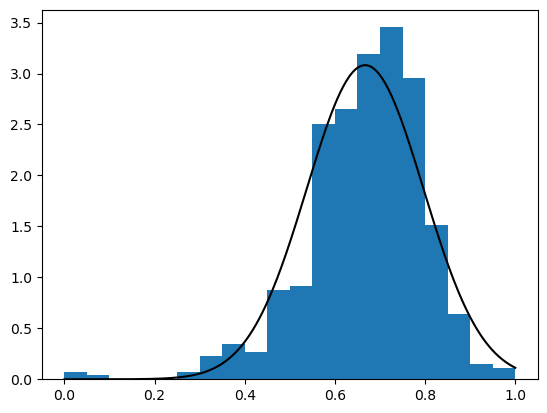

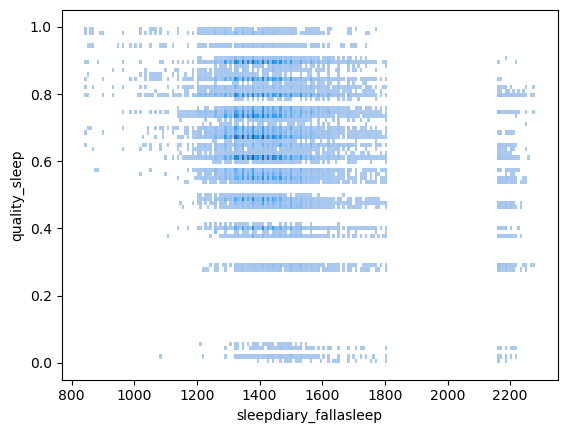

In [ ]:
# Правда ли что люди в отношениях спят лучше?

cleared1 = df_people[df_people["marital"] == 1]["quality_sleep"].dropna()
cleared23 = df_people[np.logical_or(df_people["marital"] == 2, df_people["marital"] == 3)]["quality_sleep"].dropna()

plt.hist(cleared1, bins = 20, density=True)
d_mean = cleared1.mean()
d_std = cleared1.std(ddof=1)
xs = np.linspace(0, 1, 300)
ys = stats.norm(loc = d_mean, scale = d_std).pdf(xs)
plt.plot(xs, ys, color = "black")
plt.show()

preanalysis_part2(df_sleep, "sleepdiary_fallasleep", "quality_sleep")